In [1]:

import sys
root = '/home/emastr/github/multireference-alignment/'
from multiprocessing import Pool
from alignment_vmap import *
import numpy as np
from numpy.fft import fft, ifft

import jax
import time
from jax import vmap, grad, jit, random, lax
from jax import numpy as jnp
from jax.numpy.fft import fft as jfft, ifft as jifft
from util.logger import EventTracker
import matplotlib.pyplot as plt
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, loss_fft
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion
from itertools import product


MAXITER = int(1e5)
def get_signal(L):
    ## GENERATE SIGNAL
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    #x = jnp.sin(t)
    x = (t < np.pi).astype(float)
    #x = np.random.randn(L)
    return t, x


def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

def get_mse(x, y):
    return jnp.mean((x - y) ** 2)

def get_snr(x, noise_std):
    return get_mse(x, jnp.mean(x)) / noise_std ** 2

def get_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, 0.0)

def get_mean_centered_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, jnp.mean(x))

def get_aligned_rel_mse(x, y):
    y_al = align(jfft(x), jfft(y), y)
    return get_rel_mse(x, y_al) ** 0.5

def em_run(x0, y, noise_std):
    return em_method(jfft(x0), y, noise_std, tol=1e-6, batch_niter=3000, full_niter=MAXITER)

def fpi_mom_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    
    yfft = vmap(project_moments, (0, None, None))(yfft, y_auto_fft, y_mean)

    return  ifft(fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER)).real

def fpi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    
    #yfft = vmap(project_moments, (0, None, None))(yfft, y_auto_fft, y_mean)

    return  ifft(fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER)).real

def align_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    
    #yfft = vmap(project_moments, (0, None, None))(yfft, y_auto_fft, y_mean)

    return  ifft(fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER, project=False)).real


def fpi_em_run(x0, y, noise_std):
    x = em_method(jfft(x0), y, noise_std, tol=1e-6, batch_niter=3000, full_niter=MAXITER)
    N, L = y.shape
    yfft = jfft(y, axis=1)
    #y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_auto_fft = jnp.abs(fft(x)) ** 2
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    return ifft(fix_point_iter(jfft(x), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER)).real

def bsi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_mean, yc_auto_fft, B = invariants_from_data(y, noise_std)
    x, x2, _ = bispectrum_inversion(y_mean, yc_auto_fft, B, tol=1e-6, maxiter=(15, 500))
    if loss_fft(jfft(x), yfft) > loss_fft(jfft(x2), yfft):
        x = x2
    return x


def algn_run(x0, y, noise_std):
    return ifft(align_average(jfft(x0),  fft(y, axis=1))).real


def run_many(M):
    def decorator(func):
        def wrapper(key, *args, **kwargs):
            keys = random.split(key, M)
            vals = jnp.array([func(keys[m], *args, **kwargs) for m in range(M)])
            return vals
        return wrapper
    return decorator


def average_std(M):
    def decorator(func):
        def wrapper(key, *args, **kwargs):
            keys = random.split(key, M)
            vals = jnp.array([func(keys[m], *args, **kwargs) for m in range(M)])
            return {"mean": jnp.mean(vals, axis=0), "std": jnp.std(vals, axis=0)}
        return wrapper
    return decorator

@run_many(20)
def run_methods(key, x, N, noise_std, methods):
    y, noise, shift = get_samples(key, x, noise_std, N)

    xfft = fft(x)
    x_auto_fft = jnp.abs(xfft)**2.

    
    # Add oracle - the other methods do not have access to the noise
    oracle = lambda x0, y, noise_std: x + jnp.mean(noise, axis=0)
    
    
    def oracle_fpi(x0, y, noise_std):
        yfft = jfft(y, axis=1)
        y_mean = jnp.mean(yfft[:, 0])  # Mean of means
        return  ifft(fix_point_iter(fft(x0), yfft, x_auto_fft, y_mean, alpha=1.0, tol=1e-20, maxiter=3000)).real

    methods = methods + (oracle, oracle_fpi)
    
    # Run methods
    def run(method):
        t = time.time()
        val = get_aligned_rel_mse(x, method(y[0, :].copy(), y, noise_std))
        t = time.time() - t
        return val, t
    return jnp.array([run(method) for method in methods])


# Main parameters
L = 41
N = int(1e4)
t, x = get_signal(L)

noise_stds = jnp.logspace(-2, 1., 20)
print(noise_stds)
keys = random.split(random.PRNGKey(0), len(noise_stds))

errs = []
for i, (ns, k) in enumerate(zip(noise_stds, keys)):
    print(f'RUN: std={ns}, total {i+1}/{len(noise_stds)} steps')
    errs.append(run_methods(k, x, N, ns, (align_run, em_run, fpi_run, fpi_mom_run, bsi_run)))


#def f(x):
    #out = run_methods(x[0], x, N, x[1], (em_run, fpi_run))
    #print(f"Done with ns={x[1]}")
    #return out

#if __name__ == '__main__':
    #with Pool(10) as p:
        #errs = p.map(f, [(k, ns) for ns, k in zip(noise_stds, keys)])
    
#print(errs)

jnp.save(f'{root}data/alignment_methods.npy', errs)


I0000 00:00:1725665711.511439  173757 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[ 0.01        0.0143845   0.02069138  0.02976351  0.04281333  0.06158483
  0.08858667  0.12742752  0.18329808  0.26366505  0.37926906  0.54555947
  0.78475994  1.128838    1.6237767   2.3357215   3.3598185   4.8329306
  6.951928   10.        ]
RUN: std=0.009999999776482582, total 1/20 steps
RUN: std=0.014384498819708824, total 2/20 steps
RUN: std=0.02069137990474701, total 3/20 steps
RUN: std=0.029763512313365936, total 4/20 steps
RUN: std=0.04281333461403847, total 5/20 steps
RUN: std=0.06158483400940895, total 6/20 steps
RUN: std=0.08858667314052582, total 7/20 steps
RUN: std=0.12742751836776733, total 8/20 steps
RUN: std=0.18329808115959167, total 9/20 steps
RUN: std=0.2636650502681732, total 10/20 steps
RUN: std=0.3792690634727478, total 11/20 steps
RUN: std=0.5455594658851624, total 12/20 steps
RUN: std=0.7847599387168884, total 13/20 steps
RUN: std=1.1288379430770874, total 14/20 steps
RUN: std=1.6237766742706299, total 15/20 steps


(20, 7, 2)
(20, 20, 7, 2)


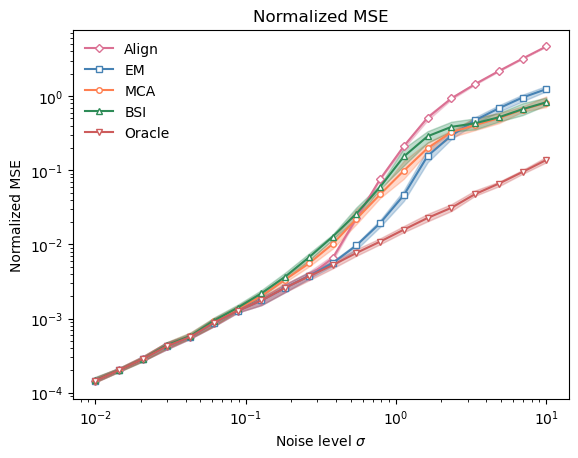

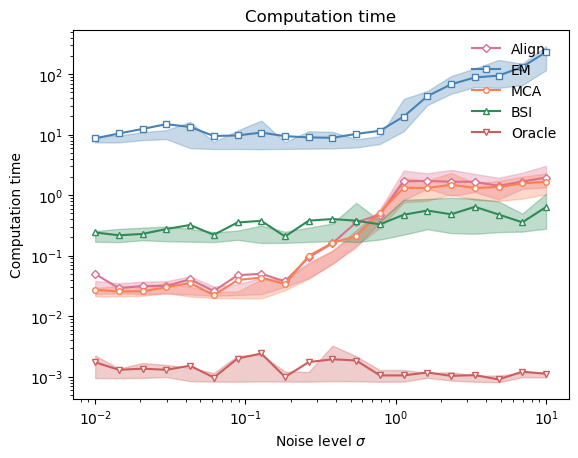

In [ ]:

# DATA: errs = {mean: method x (val, time), std: method x (val, time)}
err_vec=np.array(errs)
print(errs[0].shape)
colors = ["palevioletred", "steelblue", "coral", "seagreen", "indianred", "olivedrab"]
styles = ["-D", "-s", "-o", "-^", "-v", "+"]
    
alpha = 0.2
print(err_vec.shape)
for j, name in enumerate(['Normalized MSE', 'Computation time']):
    idx = 0
    fig = plt.figure()
    for i, method in enumerate(['Align', 'EM', 'MCA', 'MCA-norm', 'BSI', 'Oracle', 'Known amp FPI']):
        if method not in ['Known amp FPI', 'MCA-norm']:#, 'EM-FPI', 'Known amp FPI']:
            
            err_sort = np.sort(err_vec[:, :, i, j], axis=1)
            err_max = err_sort[:, int((1-alpha) * err_sort.shape[1])]
            err_min = err_sort[:, int(alpha * err_sort.shape[1])]
            err_mean = np.mean(err_vec[:, :, i, j], axis=1)
            
            
            plt.plot(noise_stds, err_mean, styles[idx], color=colors[idx], label=method, markersize=4, markerfacecolor='white')
            plt.fill_between(noise_stds, err_max, err_min, color=colors[idx], alpha=0.3)
            
            idx += 1
    plt.legend(frameon=False)
    plt.title(name)
    plt.ylabel(name)
    plt.xlabel("Noise level $\sigma$")
    plt.xscale('log')
    plt.yscale('log')
    fig.savefig(f"{root}data/plot_{j}.png", bbox_inches='tight')
    




# phase sync
# bispectrum in
# fix oracle bug (try true momets)
# sigma^6? (sigma,N)
# size=5
# numerical hessian estimate

#1) minisympo
#2) 29th april deadline posters 
#3) october conference

#1) genoa summer school 
# applied garmonic analysis ml

# sample complexity
# Check parallelism for models fft.


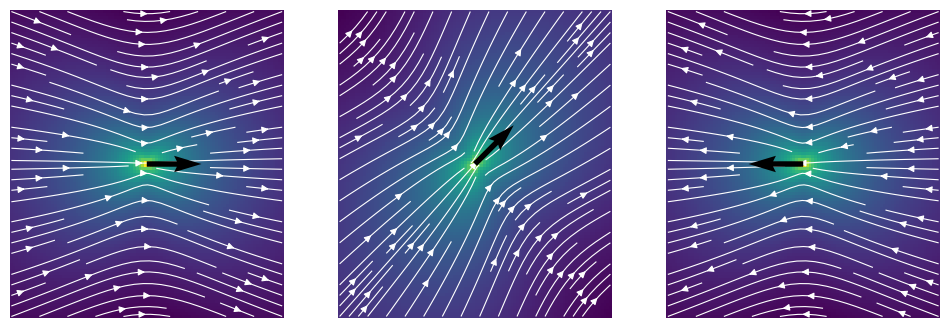

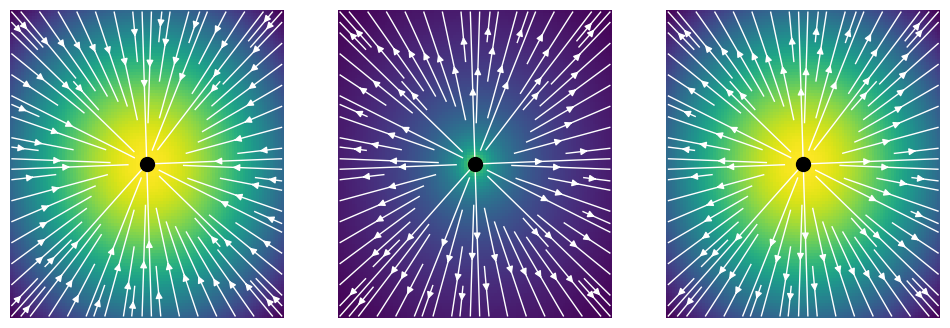

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random, jit, vmap
import matplotlib.pyplot as plt

def stokeslet(x, y, u, v):
    r = (x**2 + y**2)**0.5
    proj = (u * x + v * y) / r**3
    return u/r + x*proj, v/r + y*proj

def stokeslet_z(x, y, z, u, v, w):
    r = (x**2 + y**2+ z**2)**0.5
    proj = (u * x + v * y + w * z) / r**3
    return u/r + x*proj, v/r + y*proj, w/r + z*proj


X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
plt.figure(figsize=(12,4))
for i, theta in enumerate([0, np.pi/4, np.pi]):
    plt.subplot(1,3,i+1)
    U, V = vmap(vmap(lambda x,y: stokeslet(x, y, np.cos(theta), np.sin(theta))))(X, Y)
    plt.pcolormesh(X, Y, np.log10((U**2 + V**2)**0.5))
    plt.streamplot(X, Y, U, V, color='white', linewidth=0.8)
    plt.quiver(0,0, np.cos(theta), np.sin(theta), color='k', scale=5, width=0.02, zorder=10)
    plt.axis("off")
    
plt.figure(figsize=(12,4))
for i, z in enumerate([-1, 1e-12, 1]):
    plt.subplot(1,3,i+1)
    U, V, W = vmap(vmap(lambda x,y: stokeslet_z(x, y, z, 0, 0, 1.)))(X, Y)
    plt.pcolormesh(X, Y, np.log10((U**2 + V**2 + W**2)**0.5))
    plt.streamplot(X, Y, U, V, color='white', linewidth=1.)
    plt.scatter(0,0, c='k', s=100, zorder=10)
    plt.axis("off")
    